# Thesis
## Mattia Ravasio - BEMACS - id: 3117908
## Breast Cancer recognition trough deep learning



This is the juoyter notebook for my bachelore thesis, in which a CNN application for the [BreaKHis](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/) dataset will be discussed. The models were run in PyTorch on Google Colab. All the auxiliary functions imported in this notebook can be found on the GitHub repository.

## Environment set-up

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from PIL import Image
import torch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/thesis_balanced.zip -d path_to_directory

#### Check for CUDA version 

In [3]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fn5m9_e3
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-fn5m9_e3
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=9efb94fdb1121a7c59ee9ad5197a29b89e5907c50de28a28c2ae1a158c04ebfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-pokho8l0/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin


In [5]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [6]:
%%cu
#include <iostream>
    int
    main()
{
    std::cout << "CUDA is activated\n";
    return 0;
}

CUDA is activated



#### Auxiliary functions import:

In [7]:
from stats import compute_mean_and_std
from data_trasforms import get_fundamental_transforms, get_data_augmentation_transforms, get_efficent_augmentation_transforms
from simple_net import SimpleNet
from optimizer import get_optimizer
from dataset_generator import dataset_generator
from runner import Trainer
from get_alexnet_dataframe import get_frame_from_data_alex

### Introductory dataset analysis

In [9]:
df = pd.read_csv('/content/path_to_directory/thesis_balanced/archive/Folds.csv')
df

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...


In [10]:
def classification(x):
    return x.filename.split('/')[3]

def zoom(x):
    return x.filename.split('/')[7]

def thumor(x):
    return x.filename.split('/')[5]

df['thumor']= df.apply(thumor, axis=1)

df['zoom'] = df.apply(zoom, axis=1)
    
df['class']=df.apply(classification, axis=1)

In [11]:
df

,fold,mag,grp,filename,thumor,zoom,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
...,...,...,...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant


In [12]:
len(df['filename'].unique())

7909

Since there are only 7909 unique values for images paths, the duplicated values will be removed.

In [ ]:
udf = df.drop_duplicates(subset=['filename'],keep='first')

### Enlarging train set

In [ ]:
udf.grp[udf.grp == 'train'].count()/7909

0.6328233657858137

As it can be seen the train set is around 63% of the whole data, but the optimal would be an 85/15 split between train and test (because it will becme a 75/25 later when the excessive malignant images will be dropped from the train test). So the train test must be enlarged

In [ ]:
int(7909*0.8) - udf.grp[udf.grp == 'train'].count()

1322

In [ ]:
udf.loc[udf[udf.grp == 'test'].index[np.random.randint(0,len(udf[udf.grp == 'test'].index),2800)],:]

,fold,mag,grp,filename,thumor,zoom,class
5476,1,40,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,fibroadenoma,40X,benign
5731,1,400,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,phyllodes_tumor,400X,benign
5586,1,100,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,phyllodes_tumor,100X,benign
7908,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
6148,1,200,test,BreaKHis_v1/histology_slides/breast/malignant/...,ductal_carcinoma,200X,malignant
...,...,...,...,...,...,...,...
6730,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,ductal_carcinoma,40X,malignant
5464,1,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,fibroadenoma,200X,benign
7119,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,ductal_carcinoma,40X,malignant
5844,1,100,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,tubular_adenoma,100X,benign


In [ ]:
udf.grp[udf[udf.grp == 'test'].index[np.random.randint(0,len(udf[udf.grp == 'test'].index),2800)]] = 'train'

In [ ]:
udf.grp[udf.grp == 'train'].count()/7909

0.8607915033506133

### Visualizations of the imbalacned dataset

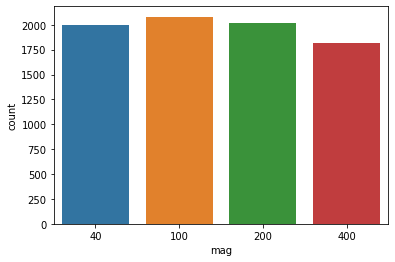

In [ ]:
sns.countplot(x=udf['mag'])

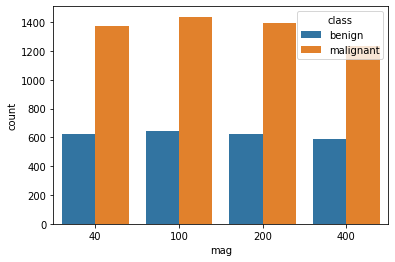

In [ ]:
sns.countplot(x=udf['mag'], hue=udf['class'])

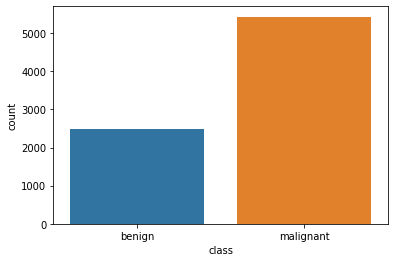

In [ ]:
sns.countplot(x=udf['class'])

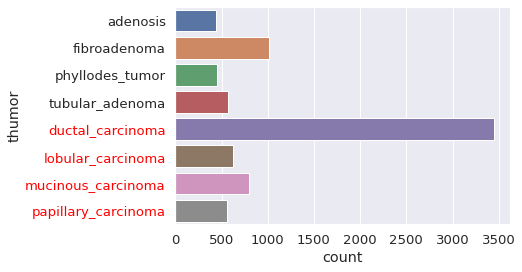

In [ ]:
sns.set(font_scale = 1.2)
for i in range(4,8):
    sns.countplot(y=udf['thumor']).axes.get_yticklabels()[i].set_color("red")

### Dataset Balancing

In [ ]:
udf['class'].value_counts()

malignant    5429
benign       2480
Name: class, dtype: int64

In [ ]:
udf['class'][udf.grp == 'train'].value_counts()

malignant    4717
benign       2091
Name: class, dtype: int64

In [ ]:
udf['class'][udf.grp == 'test'].value_counts()

malignant    712
benign       389
Name: class, dtype: int64

I will now take out some malignant images from the train set to achieve a better balance.

In [ ]:
bdf = udf.drop(udf[(udf['class']=='malignant') & (udf['grp']=='train')].index[np.random.randint(0,4691,3000)])
bdf

,fold,mag,grp,filename,thumor,zoom,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,100X,benign
...,...,...,...,...,...,...,...
7904,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
7905,1,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
7906,1,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant
7907,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,papillary_carcinoma,400X,malignant


In [ ]:
bdf['class'][udf.grp == 'train'].value_counts()

malignant    2512
benign       2091
Name: class, dtype: int64

Now the train test has been balanced while the test set hasn't, so the new perchetage of data in the train set will be displayed

In [ ]:
bdf.grp[bdf.grp == 'train'].count()/bdf.shape[0]

0.8069775596072931

### Visualizations with balanced train set

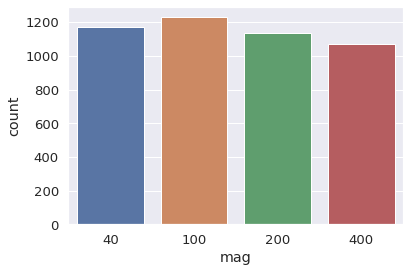

In [ ]:
sns.countplot(x=bdf['mag'][bdf.grp == 'train'])

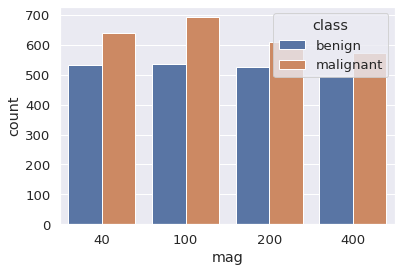

In [ ]:
sns.countplot(x=bdf['mag'][udf.grp == 'train'], hue=bdf['class'][bdf.grp == 'train'])

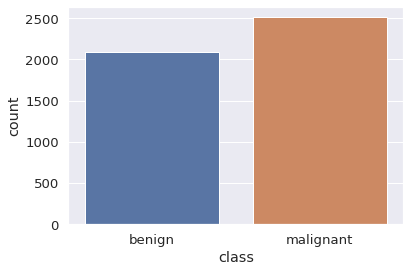

In [ ]:
sns.countplot(x=bdf['class'][bdf.grp == 'train'])

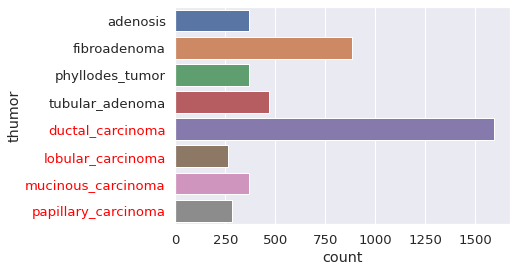

In [ ]:
sns.set(font_scale = 1.2)
for i in range(4,8):
    sns.countplot(y=bdf['thumor'][bdf.grp == 'train']).axes.get_yticklabels()[i].set_color("red")

### Dataset Generator


Here I built the train and test folders in order to be compatibel with the troch ImageFolder and DataLoader finctions. This commmand has already been run once and thus the folder with the data has already been created. It is commented in order to avoid duplicating the data folders in the future. 

In [ ]:
###dataset_generator(bdf)

folder succesfully generated


### Statistics computation


I created this function to obtain the mean and standard deviation of the dataset in order to later normalize the data. The first cell has the auxiliary function that calculates the mean and standard deviation, the second has the results of the first cell assigned to two variables in ordero to not run twice the statistics computation if the notebook was to be run in different moments. 

In [ ]:
###dataset_mean,dataset_std = compute_mean_and_std(bdf)

In [ ]:
dataset_mean,dataset_std = (np.array([0.72728666]), np.array([0.15680092]))

## Models

### New custom architecture

Here there is the experimentation with the CustomNet architecture, a CNN that leverages residual learning and a residual inception block. More on this architecture can be foun in the thesis and in the "custonet.py" file.

In [ ]:
from customnet import CustomNet

In [ ]:
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3*1e-5,
  "weight_decay": 1e-2
}
custom = CustomNet()
optimizer = get_optimizer(custom, optimizer_config)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
inp_size = (230, 350)
data_base_path = '/content/path_to_directory/thesis_balanced/data'
model_base_path = '/content/path_to_directory/thesis_balanced/models'
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available()

In [ ]:
trainer = Trainer(data_dir=data_base_path, 
                  model = custom,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'customnet'),
                  train_data_transforms = get_efficent_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 16,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [ ]:
trainer.train(num_epochs=110)

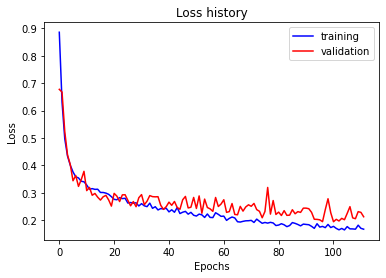

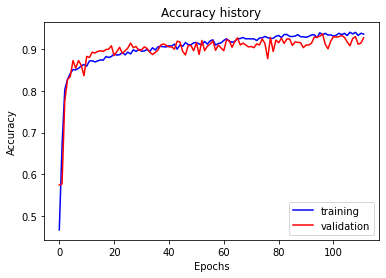

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9354; Validation Accuracy = 0.9266


In [ ]:
trainer.confusion_matrix()

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  342  |  23  | 
            r     ---------------- 
            u  1  |  58   |  680 | 
            e     ---------------- 

Accuracy: 0.9265639165911151
Sensitivty: 0.9214092140921409
Specificity: 0.936986301369863
Precision: 0.9672830725462305
Negative predictive value:0.855
Recall: 0.9214092140921409
F1 score: 0.9437890353920888


#### Fine-tuning process

Now the learning rate will be decreased and the parameters of the original ResNet34 will be made able to learn. This is the fine tuning stage of the CustomNet.

In [ ]:
for param in custom.parameters():
            param.requires_grad = True

In [ ]:
dd = trainer.optimizer.state_dict()

In [ ]:
dd['param_groups'][0]['lr'] = 3*1e-6

In [ ]:
trainer.optimizer.load_state_dict(dd)

In [ ]:
trainer.train(num_epochs=30)

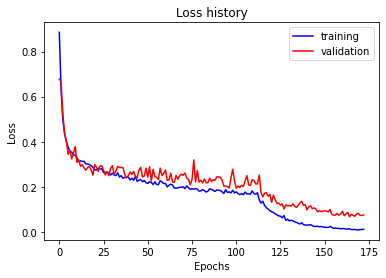

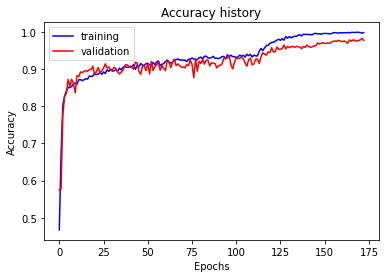

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9982; Validation Accuracy = 0.9801


In [ ]:
trainer.confusion_matrix()

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  355  |  10  | 
            r     ---------------- 
            u  1  |  12   |  726 | 
            e     ---------------- 

Accuracy: 0.9800543970988214
Sensitivty: 0.983739837398374
Specificity: 0.9726027397260274
Precision: 0.9864130434782609
Negative predictive value:0.9673024523160763
Recall: 0.983739837398374
F1 score: 0.9850746268656717


In [ ]:
torch.save(custom.state_dict(), '/content/checkpoint_custom.pt' )

### AlexNet


This is the first transfer learning approach, where the use of an AlexNet will be leveraged. 

In [ ]:
from my_alexnet import MyAlexNet

In [ ]:
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3*1e-5,
  "weight_decay": 1e-6
}
my_alexnet = MyAlexNet()
optimizer = get_optimizer(my_alexnet, optimizer_config)


In [ ]:
inp_size = (230, 350)
data_base_path = '/content/path_to_directory/thesis_balanced/data'
model_base_path = '/content/path_to_directory/thesis_balanced/models'
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() 

In [ ]:
trainer = Trainer(data_dir=data_base_path, 
                  model = my_alexnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [ ]:
trainer.train(num_epochs=50)

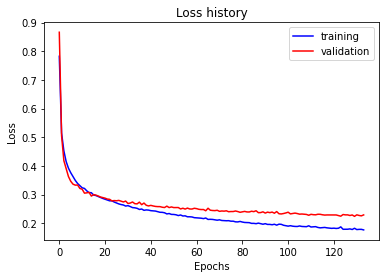

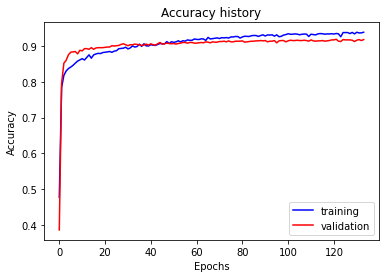

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9389; Validation Accuracy = 0.9184


In [ ]:
trainer.confusion_matrix()

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  320  |  45  | 
            r     ---------------- 
            u  1  |  45   |  693 | 
            e     ---------------- 

Accuracy: 0.9184043517679057
Sensitivty: 0.9390243902439024
Specificity: 0.8767123287671232
Precision: 0.9390243902439024
Negative predictive value:0.8767123287671232
Recall: 0.9390243902439024
F1 score: 0.9390243902439024


### ResNet34

Here a pre-trained ResNet34 will be evaluated. This model will turn out to be the best among the transfer-learning ones.

In [ ]:
from my_resnet34 import MyResNet34

In [ ]:
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3*1e-4,
  "weight_decay": 1e-3
}
my_resnet = MyResNet34()
optimizer = get_optimizer(my_resnet, optimizer_config)

In [ ]:
inp_size = (230, 350)
data_base_path = '/content/path_to_directory/thesis_balanced/data'
model_base_path = '/content/path_to_directory/thesis_balanced/models'
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available()

In [ ]:
trainer = Trainer(data_dir=data_base_path, 
                  model = my_resnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'resnet'),
                  train_data_transforms = get_data_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [ ]:
trainer.train(num_epochs=30)

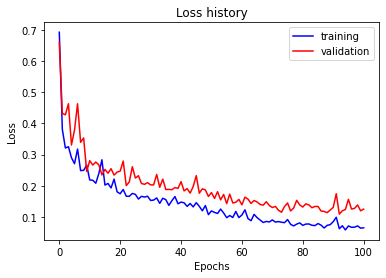

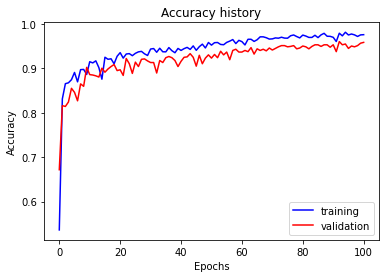

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9756; Validation Accuracy = 0.9583


In [ ]:
trainer.confusion_matrix()

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  356  |  9  | 
            r     ---------------- 
            u  1  |  37   |  701 | 
            e     ---------------- 

Accuracy: 0.958295557570263
Sensitivty: 0.9498644986449865
Specificity: 0.9753424657534246
Precision: 0.9873239436619718
Negative predictive value:0.905852417302799
Recall: 0.9498644986449865
F1 score: 0.9682320441988951


### VGGNet 

Here the the performance of a VGGnet 16 can be seen

In [ ]:
from my_vggnet import MyVGGNet16

In [ ]:
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3*1e-5,
  "weight_decay": 1e-4
}
my_vgg = MyVGGNet16()
optimizer = get_optimizer(my_vgg, optimizer_config)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
inp_size = (230, 350)
data_base_path = '/content/path_to_directory/thesis_balanced/data'
model_base_path = '/content/path_to_directory/thesis_balacned/models'
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() 

In [ ]:
trainer = Trainer(data_dir=data_base_path, 
                  model = my_vgg,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'vggnet'),
                  train_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [ ]:
trainer.train(num_epochs=30)

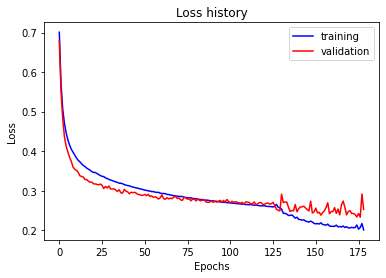

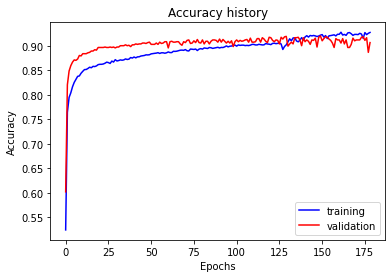

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9273; Validation Accuracy = 0.9066


In [ ]:
trainer.confusion_matrix()

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  321  |  44  | 
            r     ---------------- 
            u  1  |  59   |  679 | 
            e     ---------------- 

Accuracy: 0.9066183136899365
Sensitivty: 0.9200542005420054
Specificity: 0.8794520547945206
Precision: 0.9391424619640387
Negative predictive value:0.8447368421052631
Recall: 0.9200542005420054
F1 score: 0.9295003422313484


### Efficient Net B0





This is the code for the Efficient Net B0

In [ ]:
from my_efficientnetb0 import MyEfficentnetB0

In [ ]:
from typing import Tuple

import torchvision.transforms as transforms
import numpy as np


def get_data_augmentation_transforms(inp_size, pixel_mean, pixel_std):

    return transforms.Compose(
        [
            
            transforms.Resize(inp_size),
            transforms.RandomRotation(30),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.ColorJitter (brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomAffine(0,(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(pixel_mean, pixel_std, inplace=True)
        ]
    )



In [ ]:
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 3*1e-4,
  "weight_decay": 1e-2
}
my_eff = MyEfficentnetB0()
optimizer = get_optimizer(my_eff, optimizer_config)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
inp_size = (230, 350)
data_base_path = '/content/path_to_directory/thesis_balanced/data'
model_base_path = '/content/path_to_directory/thesis_balanced/models'
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available()

In [ ]:
trainer = Trainer(data_dir=data_base_path, 
                  model = my_eff,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 64,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [ ]:
trainer.train(num_epochs=40)

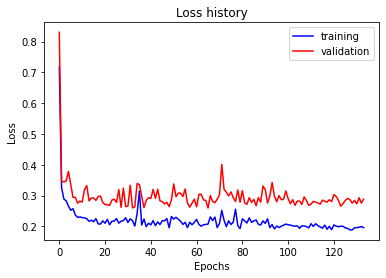

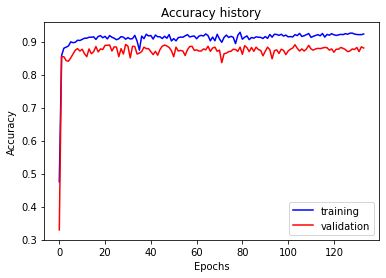

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.9229; Validation Accuracy = 0.8803


In [ ]:
trainer.confusion_matrix()

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  322  |  43  | 
            r     ---------------- 
            u  1  |  89   |  649 | 
            e     ---------------- 

Accuracy: 0.8803263825929284
Sensitivty: 0.8794037940379403
Specificity: 0.8821917808219178
Precision: 0.9378612716763006
Negative predictive value:0.7834549878345499
Recall: 0.8794037940379403
F1 score: 0.9076923076923076


### XGBoost classifier


Here a convolutioanl XGBoost will be evaluated. The model is made up of the feature extraction part of the pre-trained AlexNet, and an XGBoost classifier

In [ ]:
my_alexnet.to('cpu')

xgb_test = get_frame_from_data_alex(my_alexnet,
                                    '/content/path_to_directory/thesis_balanced/data',
                                    inp_size,
                                    dataset_mean,
                                    dataset_std ,
                                    'test' )

In [ ]:
### To save feature extracted
xgb_test.to_pickle("xgb_test.pkl")

In [ ]:
xgb_train = get_frame_from_data_alex(my_alexnet, '/content/path_to_directory/thesis_balanced/data', inp_size, dataset_mean, dataset_std, 'train' )


In [ ]:
### To save feature extracted
xgb_train.to_pickle("xgb_train.pkl")

In [ ]:
xgb_test = pd.read_pickle("/content/xgb_test.pkl")

In [ ]:
xgb_test

,feature,class
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"[0.0, 0.0, 0.0, 0.5733544, 0.777936, 0.0, 0.0,...",0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.8352599, 2.6861143...",0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
1098,"[0.08707843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
1099,"[1.4398767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1101,"[0.8090333, 0.0, 0.0, 0.0, 0.30279192, 0.82967...",0


In [ ]:
len(xgb_test['feature'][0])

9216

In [ ]:
l=[]
for x,y in xgb_test['feature'].iteritems():
    l.append(y)
    
XGB_test = pd.concat([pd.DataFrame(np.array(l)),xgb_test['class']],axis=1)

In [ ]:
XGB_test

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.163952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.000000,0.0,0.0,0.573354,0.777936,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.245834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,2.103850,0.311706,0.291864,1.196880,1.540287,1.325632,2.362518,0.000000,0.000000,1
3,0.000000,0.0,0.0,0.000000,0.000000,0.835260,2.686114,0.404865,0.0,0.000000,...,0.404696,0.188840,0.000000,0.000000,0.000000,0.000000,0.942901,0.942901,0.000000,0
4,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.037357,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,0.087078,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004172,0
1099,1.439877,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.692512,0.000000,0.000000,0.000000,0.000000,0.000000,0
1100,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.097568,0.097568,0.000000,0.000000,1
1101,0.809033,0.0,0.0,0.000000,0.302792,0.829676,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.230251,0.354584,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
xgb_train = pd.read_pickle("/content/xgb_train.pkl")

l=[]
for x,y in xgb_train['feature'].iteritems():
    l.append(y)
    
XGB_train = pd.concat([pd.DataFrame(np.array(l)),xgb_train['class']],axis=1)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(XGB_train.drop('class',axis=1), XGB_train['class'])

XGBClassifier()

In [ ]:
from sklearn.metrics import confusion_matrix

def conf_matrix(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        TP = cm[1,1]
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]

        accuracy = (TP+TN)/np.sum(cm)
        sensitivity = TP/(TP+FN)
        specificity = TN/(TN+FP)
        precision = TP/(TP+FP)
        negative_pred_val = TN/(TN+FN)
        recall = sensitivity
        f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))
        
        print(f'0: Benign, 1: Malignant')
        print()
        print(f'Confusion Matrix:')
        print(f'                       predicted ')
        print(f'                      0       1         ')
        print(f'                  ---------------- ')
        print(f'            t  0  |  {TN}  |  {FP}  | ')
        print(f'            r     ---------------- ')
        print(f'            u  1  |  {FN}   |  {TP} | ')
        print(f'            e     ---------------- ')
        print()
        print(f'Accuracy: {accuracy}')
        print(f'Sensitivty: {sensitivity}')
        print(f'Specificity: {specificity}')
        print(f'Precision: {precision}')
        print(f'Negative predictive value:{negative_pred_val}')
        print(f'Recall: {recall}')
        print(f'F1 score: {f1}')

In [ ]:
xg_pred = xgbc.predict(XGB_test.drop('class',axis=1))
conf_matrix(XGB_test['class'], xg_pred)

0: Benign, 1: Malignant

Confusion Matrix:
                       predicted 
                      0       1         
                  ---------------- 
            t  0  |  296  |  69  | 
            r     ---------------- 
            u  1  |  60   |  678 | 
            e     ---------------- 

Accuracy: 0.8830462375339981
Sensitivty: 0.9186991869918699
Specificity: 0.810958904109589
Precision: 0.9076305220883534
Negative predictive value:0.8314606741573034
Recall: 0.9186991869918699
F1 score: 0.913131313131313
